In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.manifold
from sklearn.model_selection import train_test_split
import itertools
import time
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context('poster')

In [27]:
# we dont use all the available features - e.g. number of siblings on board as we assume this will not affect survival
df = pd.read_csv('train.csv', usecols=['Survived','Pclass','Sex','Age','Fare'])
df = df.fillna(df.mean())
df = df.round()
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Survived,Pclass,Sex,Age,Fare
0,0,2,male,32.0,10.0
1,0,1,male,47.0,26.0
2,0,3,male,45.0,7.0
3,0,3,male,16.0,20.0
4,1,2,female,25.0,26.0


In [28]:
# % of those who survived
sum(df.Survived)/len(df)

0.3838383838383838

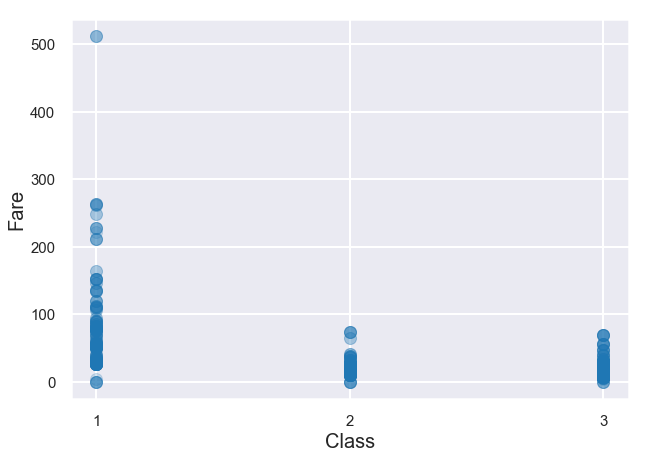

In [29]:
fares = np.array(list(df.Fare))
classes = np.array(list(df.Pclass))

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(classes,fares,'o',alpha=0.2)
ax.set_xlabel('Class', fontsize=20)
ax.set_ylabel('Fare', fontsize=20)
ax.set_xticks([1,2,3])
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [30]:
from scipy.stats import pearsonr
pearsonr(fares,classes)[0]

-0.5496377373468153

In [31]:
df.groupby(['Pclass', 'Sex'])['Survived'].mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

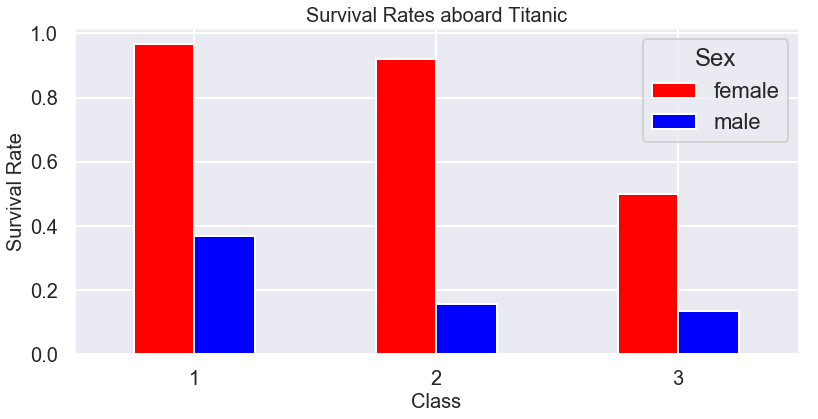

In [32]:
df.groupby(['Pclass', 'Sex'])['Survived'].mean().unstack().plot(kind='bar',figsize=(13,6), fontsize=20, color=['r','b']);
plt.ylabel('Survival Rate',fontsize=20)
plt.title('Survival Rates aboard Titanic',fontsize=20);
plt.xlabel('Class',fontsize=20);
plt.xticks([0,1,2],rotation=0);

In [33]:
# first OHE the gender feature
df = pd.get_dummies(df, columns=['Sex'])
X = df.as_matrix(columns=['Pclass','Age','Sex_female','Sex_male','Fare'])
Y = df.as_matrix(columns=['Survived'])
# normalize age and fare
X[:,1] = (X[:,1] - X[:,1].min())/(X[:,1].max() - X[:,1].min())
X[:,4] = (X[:,4] - X[:,4].min())/(X[:,4].max() - X[:,4].min())

c:\users\nok\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\nok\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [34]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=15, n_iter=2000, n_iter_without_progress=1000)
matrix_2d = tsne.fit_transform(X)

In [35]:
colors = df.Survived.values
colors = ['G' if i==1 else 'R' for i in colors]

In [36]:
df_tsne = pd.DataFrame(matrix_2d)
df_tsne['Survived'] = df['Survived']
df_tsne['color'] = colors
df_tsne.columns = ['x','y', 'Survived', 'color']
# rearrange columns
cols = ['Survived','color','x','y']
df_tsne = df_tsne[cols]
# show the 2D coordinates of the TSNE output
df_tsne.head()

,Survived,color,x,y
0,0,R,63.488758,-7.595048
1,0,R,-10.759534,-66.348526
2,0,R,42.428360,53.211483
3,0,R,27.388609,-46.904736
4,1,G,8.958615,-9.205572


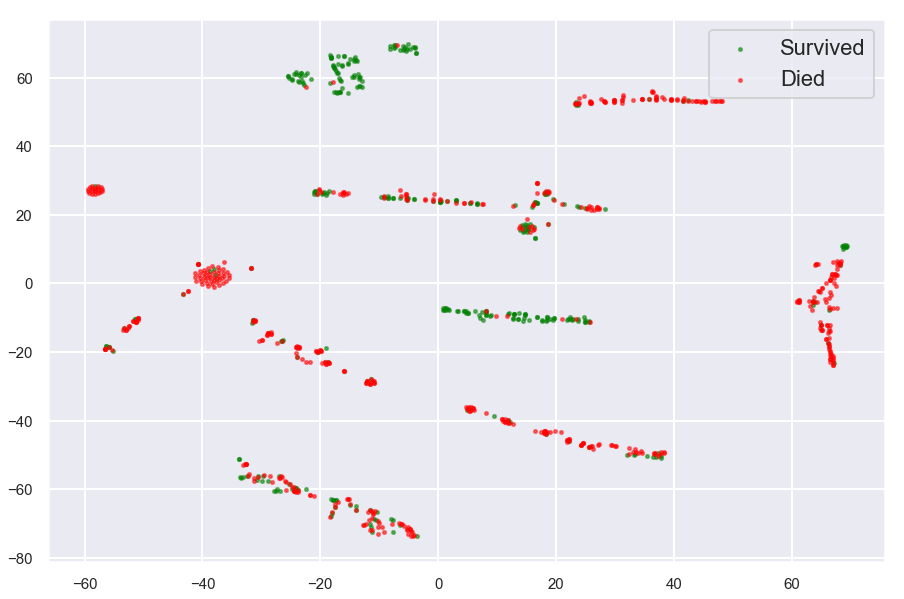

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne.Survived==1].x.values, df_tsne[df_tsne.Survived==1].y.values,
           c='green', s=10, alpha=0.5, label='Survived')
ax.scatter(df_tsne[df_tsne.Survived==0].x.values, df_tsne[df_tsne.Survived==0].y.values,
           c='red', s=10, alpha=0.5, label='Died')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()
plt.show();


In [38]:
data = df.as_matrix()
# normalize age and fare
data[:,2] = (data[:,2] - data[:,2].min())/(data[:,2].max() - data[:,2].min())
data[:,3] = (data[:,3] - data[:,3].min())/(data[:,3].max() - data[:,3].min())
X_train, X_test = train_test_split(data, test_size=0.1)
Y_train = X_train[:,0] # first column is class
Y_train = np.reshape(Y_train, newshape=(len(Y_train),1)) # reshape to a columns vector
X_train = X_train[:,1:] # select all columns but class
Y_test = X_test[:,0]
Y_test = np.reshape(Y_test, newshape=(len(Y_test),1)) # reshape to a columns vector
X_test = X_test[:,1:]

c:\users\nok\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [39]:
def sigmoid(x, deriv=False):
    """
    Sigmoid activation function
    """
    if(deriv==True):
        return (x*(1-x))
    return 1/(1+np.exp(-x))

In [40]:
def relu(x, deriv=False):
    """
    Leaky ReLU activation function
    """
    if deriv == True:
        x[x<0] = 0.01
        x[x>0] = 1.
        return x
    x[x<0] = 0.01*x[x<0]
    return x

In [41]:
def predict(x, w0, w1, b1, b2):
    """
    Function to predict an output given a data x, weight matrices w1 & w1 and biases b1 & b2
    """
    A = np.dot(x,w0) + b1 # mXN X NxH +1xH ~ mxH
    layer_1 = relu(A)
    B = np.dot(layer_1,w1) + b2 # mxH X Hx1 ~ mx1 (preds)
    layer_2 = B
    return (sigmoid(layer_2) > 0.5).astype(int)

In [42]:
def get_batch(x,y,i,batchSize=32):
    """
    Function that returns a minibatch of a dataset
    """
    return x[i:i+batchSize],y[i:i+batchSize]

In [43]:
# learning rate, hidden layer dimension, dropout rate, batch size
alpha, hidden_size, drop_rate, batch_size = (0.04,32,0.5,32)
# randomly initialise synapses
syn0 = 2*np.random.random((X_train.shape[1],hidden_size)) - 1 # NxH
syn1 = 2*np.random.random((hidden_size,1)) - 1 # Hx1
# randomly initialise biases
b1 = np.random.randn(hidden_size) # 1xH
b2 = np.random.randn(1) # 1x1
avg_err = []

for epoch in range(2000):
    err = []

    for i in range(int(X_train.shape[0]/batch_size)):

        x,y = get_batch(X_train,Y_train,i,batch_size)

        # Forward
        layer_0 = x
        A = np.dot(layer_0,syn0) + b1 # BxN X NxH ~ BxH
        layer_1 = relu(A)
        # drop out to reduce overfitting
        layer_1 *= np.random.binomial([np.ones((len(x),hidden_size))],1-drop_rate)[0] * (1/(1-drop_rate))

        B = np.dot(layer_1,syn1) + b2 # BxH X Hx1 ~ Bx1
        layer_2 = sigmoid(B)

        # Backprop
        layer_2_error = layer_2 - y # Bx1
        layer_2_delta = layer_2_error * sigmoid(layer_2,deriv=True) # Bx1 * Bx1 ~ Bx1

        layer_1_error = np.dot(layer_2_delta,syn1.T) # Bx1 X 1xH ~ BxH
        layer_1_delta = layer_1_error * relu(layer_1,deriv=True) # BxH * BxH ~ BxH

        # update weights
        syn1 -= alpha*np.dot(layer_1.T,layer_2_delta) # HxB X Bx1 ~ Hx1
        syn0 -= alpha*np.dot(layer_0.T,layer_1_delta) # NxB X BxH ~ NxH

        # update biases
        m = len(y)
        b2 -= alpha * (1.0 / m) * np.sum(layer_2_delta)
        b1 -= alpha * (1.0 / m) * np.sum(layer_1_delta)

        err.append(layer_2_error)

    avg_err.append(np.mean( np.abs(err) ))
    if epoch%500 == 0:
        print("Epoch: %d, Error: %.8f" % (epoch, np.mean( np.abs(err) )))

Epoch: 0, Error: 0.42790906
Epoch: 500, Error: 0.21918871
Epoch: 1000, Error: 0.23107648
Epoch: 1500, Error: 0.22428582


In [44]:
# accuracy on training set
100*(1-np.sum(np.abs(predict(X_train, syn0, syn1, b1, b2) - Y_train))/len(X_train))

77.02871410736579

In [45]:
# accuracy on test set
100*(1-np.sum(np.abs(predict(X_test, syn0, syn1, b1, b2) - Y_test))/len(Y_test))

77.77777777777779